# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
from Timer import Timer
import IPythonMagic
import logging

In [3]:
import pytest
from ipytest import run_pytest, clean_tests

In [4]:
%setup_logging
%cuda_context_handler context

Python version 2.7.5 (default, Jul 13 2018, 13:06:57) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-28)]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (8, 0, 0)
Driver version 9010
Using 'Quadro K2000' GPU
 => compute capability: (3, 0)
 => memory: 1875 / 1999 MB available
Created context handle <58276784>
Using CUDA cache dir /home/jobic/test/cuda/milan2018/MilanoGPU2018/notebooks/cuda_cache


In [5]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [6]:
def gpuMatrixVector(a,b):
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    a_g = GPUArray(a.shape, np.float32)
    b_g = GPUArray(b.shape, np.float32)
    a_g.set(a)
    b_g.set(b)
    
    #Allocate output data
    c_g = GPUArray(a.shape[0], np.float32)
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)

    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    
    #Execute program on device
    kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)

    #Copy data from device to host
    c = np.empty((a.shape[0], 1), dtype=np.float32)
    c_g.get(c)
    pass #To skip printing of c

    return c

/home/jobic/jupyter-virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
My Timer Tag: 43.792963 ms


Block size is (128, 1, 1)
Grid size is (31, 1, 1)
It took 0.043792963028 seconds


/home/jobic/jupyter-virtualenv/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/jobic/jupyter-virtualenv/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


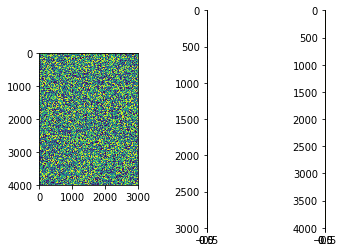

In [7]:
#Size of our test
test_size = (4000, 3000)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
with Timer("My Timer Tag", logging.INFO) as t:
    c = gpuMatrixVector(a,b)
print("It took " + str(t.secs) + " seconds")

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [8]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 24087.085937500000000000000000000000
Per element error: 8.029028645833334


In [9]:
clean_tests()

def test_gpuMatrixVector():
    #Let test a maxtrix of size 1x1
    a = np.ones((1,1), dtype=np.float32)
    b = 2*np.ones((1,1), dtype=np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(2.0)
    
    #Test that the inner product works
    a = np.ones((1,2), dtype=np.float32)
    b = 2*np.ones((2,1), dtype=np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(4.0)    
    
    #Size of our test
    test_size = (4, 3)

    #Create test input / output data
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(np.dot(a,b))
    
run_pytest(filename='MatrixVectorProductTesting.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux2 -- Python 2.7.5, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /home/jobic/jupyter-virtualenv/bin/python
cachedir: .pytest_cache
rootdir: /home/jobic/test/cuda/milan2018/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorProductTesting.py::test_gpuMatrixVector <- <ipython-input-9-9a789f7e6f1c> FAILED [100%]

=================================== FAILURES ===================================
_____________________________ test_gpuMatrixVector _____________________________

    def test_gpuMatrixVector():
        #Let test a maxtrix of size 1x1
        a = np.ones((1,1), dtype=np.float32)
        b = 2*np.ones((1,1), dtype=np.float32)
>       c = gpuMatrixVector(a,b)

<ipython-input-9-9a789f7e6f1c>:7: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
<ipython-input-6-14dcfaaeecef>:22: in gpuMatrixVector
    kernel(c_g, a_g, b_g, np.int32(a.sha

1